# Azimuthal averaging in log-scaled bins

PyFAI has been optimized for histogramming data on uniform bins. 
Neverthless one can perform this histogramming in a different space. 
This cookbook explains how to choose the proper radial unit. 

First of all we will generate an image with some realistic noise and integrate it. 
Then we will observe the effects of the output space and finally we will create our own output space.

## Guinier-like scatterer image

In [1]:
%matplotlib nbagg

In [2]:
#import ipympl
from matplotlib import pyplot as plt
import numpy

In [3]:
import pyFAI, pyFAI.azimuthalIntegrator
from pyFAI.gui import jupyter
det = pyFAI.detector_factory("Pilatus100k")
ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=1, detector=det)
ai.wavelength=1e-10
q = ai.array_from_unit(unit="q_nm^-1")

/mntdirect/_scisoft/users/jupyter/jupy35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
#Guinier-like scatterer
I = 1e6*numpy.exp(-q**2/2)
#Add some noise to make it look real
Y = numpy.random.poisson(I)

<IPython.core.display.Javascript object>


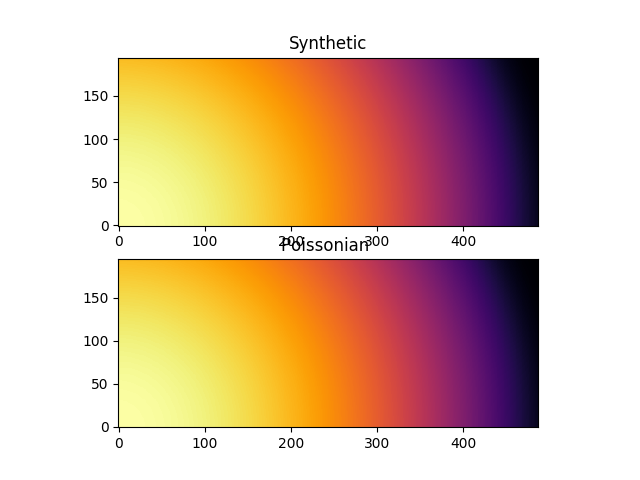

In [5]:
fig, ax = plt.subplots(2)
jupyter.display(I, ax=ax[0], label="Synthetic")
jupyter.display(I, ax=ax[1], label="Poissonian ")
fig.show()

<IPython.core.display.Javascript object>


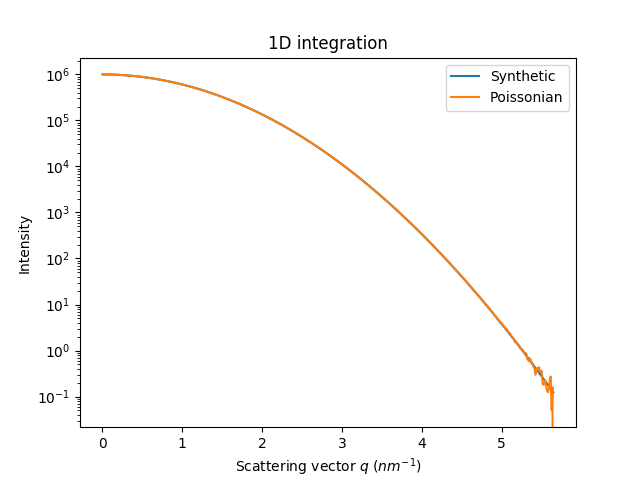

In [6]:
fig, ax = plt.subplots()
jupyter.plot1d(ai.integrate1d(I, 500),ax=ax, label="Synthetic")
ax.plot(*ai.integrate1d(Y, 500), label="Poissonian")
ax.legend()
ax.semilogy()
fig.show()

## Selection of the log-space rebinning

In this section we see how to switch to log-scale at the integration level (and revert back to q_nm^-1 for plotting).

PyFAI does not like negative radial units. Hence log(q) has to be prohibited. I would recommend the $arcsinh$ functions which is a well behaved function from R -> R with a slope at the origin of 1 and a log-scale behaviour.

<IPython.core.display.Javascript object>


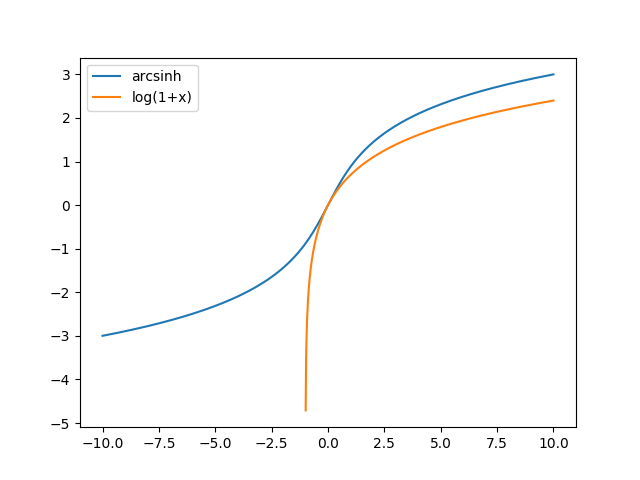

/mntdirect/_scisoft/users/jupyter/jupy35/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


In [7]:
x = numpy.linspace(-10, 10, 1000)
fig, ax = plt.subplots()
ax.plot(x, numpy.arcsinh(x), label="arcsinh")
ax.plot(x, numpy.log1p(x), label="log(1+x)")
ax.legend()
fig.show()

<IPython.core.display.Javascript object>


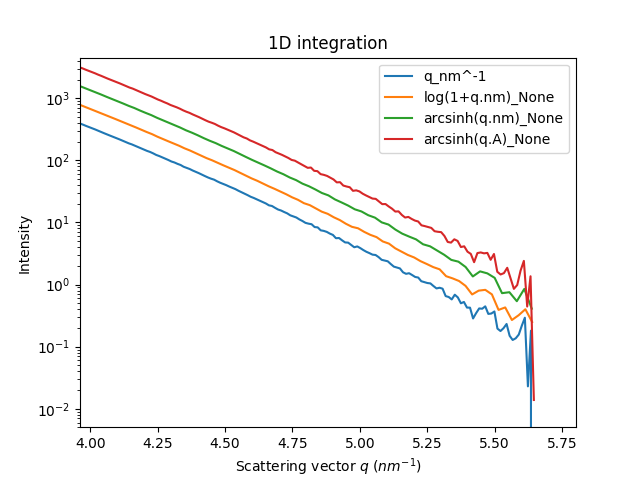

In [8]:
fig, ax = plt.subplots()
method="splitpixel"
jupyter.plot1d(ai.integrate1d(Y, 500, method=method),ax=ax, label="q_nm^-1")
ax.semilogy()
x,y = ai.integrate1d(Y, 500, unit="log(1+q.nm)_None", method=method)
ax.plot(numpy.exp(x)-1,y*2, label="log(1+q.nm)_None")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.nm)_None", method=method)
ax.plot(numpy.sinh(x), y*4, label="arcsinh(q.nm)_None")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.A)_None", method=method)
ax.plot(numpy.sinh(x)*10, y*8, label="arcsinh(q.A)_None")

ax.legend()
fig.show()

Going to log-scale helps to reduce the noise at high $q$ as on can see in the log(1+q.nm) or arcsinh(q.nm). 
The maximum value for $q$ is only 0.56${A}$, so after taking the log scale this remain in the linear part of the curve.
On the opposite, one would like to histogram on bins with larger numerical values. This is what we will see now. 

## Creation of a new radial unit

Let's create the $arcsinh(q.µm)$ unit. 
$q$ in inverse micrometer has numerical values 1000 times larger than in inverse nanometer, and should emphathize the curvature.

In [9]:
from pyFAI.units import eq_q, register_radial_unit

register_radial_unit("arcsinh(q.µm)_None",
                     scale=1.0,
                     label=r"arcsinh($q$.µm)",
                     equation=lambda x, y, z, wavelength: numpy.arcsinh(1000*eq_q(x, y, z, wavelength))) 



<IPython.core.display.Javascript object>


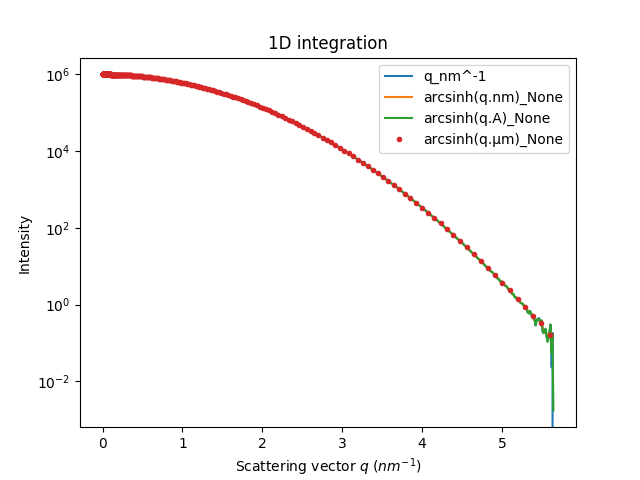

In [10]:
fig, ax = plt.subplots()
method="splitpixel"
jupyter.plot1d(ai.integrate1d(Y, 500, method=method),ax=ax, label="q_nm^-1")
ax.semilogy()
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.nm)_None", method=method)
ax.plot(numpy.sinh(x), y, label="arcsinh(q.nm)_None")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.A)_None", method=method)
ax.plot(numpy.sinh(x)*10, y, label="arcsinh(q.A)_None")
x,y = ai.integrate1d(Y, 500, unit="arcsinh(q.µm)_None", method=method)
ax.plot(numpy.sinh(x)/1000, y, ".", label="arcsinh(q.µm)_None")

ax.legend()
fig.show()

<IPython.core.display.Javascript object>


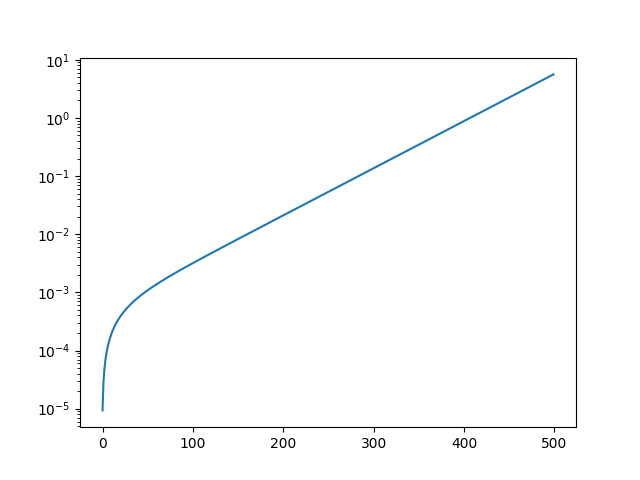

In [11]:
fig, ax = plt.subplots()
ax.plot(numpy.sinh(x)/1000)
ax.semilogy()
fig.show()

*Nota:* Expressing q in $µm^{-1}$ heavily distorts the curve in the low $q$ region, causing an oversampling near $q=0$. A factor 10 to 100 would have been better than the 1000 used in this example.

## Conclusion

We have seen how to perform azimuthal integration with variable bin-size in pyFAI, especially in the context of SAXS where it is desirable to have larger bins at large $q$ values to reduce the noise in this region.